In [1]:
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad
import torch.nn as nn
from torch.optim import Adam, LBFGS


class FCN(nn.Module): # Forward
    def __init__(self, n_input = 1, n_nodes = 5, n_hl = 3, n_output = 1):

        super(FCN, self).__init__()
        layers = [nn.Linear(n_input, n_nodes), nn.GELU()]
        for _ in range(n_hl - 1):
            layers.append(nn.Linear(n_nodes, n_nodes))
            layers.append(nn.GELU())
        layers.append(nn.Linear(n_nodes, n_output))

        self.layers = nn.Sequential(*layers)
        #self.R = nn.Parameter(torch.randn(1, 1), requires_grad = True)
        #self.L = nn.Parameter(torch.randn(1, 1), requires_grad = True)
        #self.C = nn.Parameter(torch.randn(1, 1), requires_grad = True)

    def forward(self, x):
        return self.layers(x)


t = torch.rand(4, 1)
model = FCN(n_input = 1, n_nodes = 128, n_hl = 2, n_output = 1)


Text(0.5, 1.0, 'Ground Truth Data')

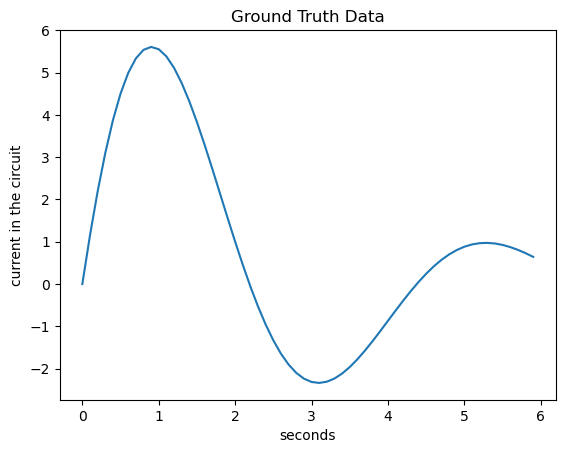

In [2]:
#ground truth
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import ode
from scipy import integrate 

R, L, C = 1.2, 1.5, 0.3
c1, c2 = R / L, 1 / (L*C)
def solv(Y, t):
   return [Y[1], -(c2*Y[0] + c1*Y[1])] 
a_t = np.arange(0, 6.0, 1e-1)
asol = integrate.odeint(solv, [0, 12], a_t)
#our solution is asol[:, 0]
plt.plot(a_t, asol[:, 0])
plt.xlabel("seconds")
plt.ylabel("current in the circuit")
plt.title("Ground Truth Data")

In [3]:
#Hyper parameters
R = torch.tensor([1.2])
L = torch.tensor([1.5])
C = torch.tensor([0.3])
VC = 12.
# t_coloc = torch.arange(0, 6, 0.3, requires_grad = True)
t_coloc = torch.arange(0, 6.0, 1e-1, requires_grad = True)
t_coloc = t_coloc.view(-1, 1)
t_init = torch.tensor([0.0], requires_grad = True)
i_init = torch.tensor([0.0], requires_grad = True)
t_init2 = torch.tensor([0.0], requires_grad = True)
v_init2 = torch.tensor([VC])

lr = 1e-3
opt = torch.optim.Adam(model.parameters(), lr = lr)

def loss_init_cond_1(model, t, x):
    out = model(t)
    return (out - x) ** 2

def loss_init_cond_2(model, x):
    global v_init2
    global L
    out = model(x)
    dfdx = grad(out, x, torch.ones_like(out), create_graph = True)[0]
    vl = dfdx * L
    return (vl - v_init2) ** 2

def loss_col_points(model, coloc):
    global R
    global L
    global C
    out = model(coloc)
    dfdx = grad(out, coloc, torch.ones_like(out), create_graph = True)[0]
    dfdx2 = grad(dfdx, coloc, torch.ones_like(dfdx), create_graph = True)[0]
    residual = dfdx2 + (R / L) * dfdx + out / (L * C)
    return residual ** 2 # sum of the residuals squared


def loss_init_cond_2_i(model, x):
    global v_init2
    out = model(x)
    dfdx = grad(out, x, torch.ones_like(out), create_graph = True)[0]
    vl = dfdx * model.L
    return (vl - v_init2) ** 2

def loss_i(model, coloc, response):

    out = model(coloc)
    return (out - response)**2


def loss_i_col_points(model, coloc):

    out = model(coloc)
    dfdx = grad(out, coloc, torch.ones_like(out), create_graph = True)[0]
    dfdx2 = grad(dfdx, coloc, torch.ones_like(dfdx), create_graph = True)[0]
    residual = dfdx2 + (model.R / model.L) * dfdx + out / (model.L * model.C)
    return residual ** 2 # sum of the residuals squared



def tr_step(model, coloc, t_init, t_init2, i_init, opt):

    opt.zero_grad()

    l1 = loss_init_cond_1(model, t_init, i_init)
    l2 = loss_init_cond_2(model, t_init2)
    l3 = loss_col_points(model, coloc)
    l = l1 + 2*l2 + l3

    l.backward()
    opt.step()

    return l.detach().numpy()


def tr_step_i(model, coloc, response, t_init, t_init2, i_init, opt, rlc = 1e-3):


    opt.zero_grad()

    l1 = loss_init_cond_1(model, t_init, i_init)
    l2 = loss_init_cond_2_i(model, t_init2)
    l3 = loss_i_col_points(model, coloc)
    l4 = loss_i(model, coloc, response)
    l = l1 + l2 + l3 + 10*l4

    l.backward()
    model.R.data.sub_(1e-3 * model.R.grad)
    model.L.data.sub_(1e-3 * model.L.grad)
    model.C.data.sub_(1e-3 * model.C.grad)
    model.R.grad.zero_()
    model.L.grad.zero_()
    model.C.grad.zero_()

    opt.step()

    return l.detach().numpy()



In [4]:
# training loop
epochs = 200
tr_loss = []
for i in range(epochs):
    for point in t_coloc:
        l = tr_step(model, point, t_init, t_init2, i_init, opt)
        tr_loss.append(l)

    if epochs % 10 == 0:
        print(f"Training Loss at epoch {i + 1}: {tr_loss[-1][0]:.6f}")

Training Loss at epoch 1: 3.268432
Training Loss at epoch 2: 0.199300
Training Loss at epoch 3: 0.102488
Training Loss at epoch 4: 0.030091
Training Loss at epoch 5: 0.028844
Training Loss at epoch 6: 0.030772
Training Loss at epoch 7: 0.031642
Training Loss at epoch 8: 0.029781
Training Loss at epoch 9: 0.026118
Training Loss at epoch 10: 0.022623
Training Loss at epoch 11: 0.021065
Training Loss at epoch 12: 0.023096
Training Loss at epoch 13: 0.029351
Training Loss at epoch 14: 0.040643
Training Loss at epoch 15: 0.059201
Training Loss at epoch 16: 0.082685
Training Loss at epoch 17: 0.114740
Training Loss at epoch 18: 0.144535
Training Loss at epoch 19: 0.173631
Training Loss at epoch 20: 0.192238
Training Loss at epoch 21: 0.206704
Training Loss at epoch 22: 0.215966
Training Loss at epoch 23: 0.228661
Training Loss at epoch 24: 0.235297
Training Loss at epoch 25: 0.248578
Training Loss at epoch 26: 0.252460
Training Loss at epoch 27: 0.265530
Training Loss at epoch 28: 0.267882
T

In [5]:
y_pred = model(t_coloc)

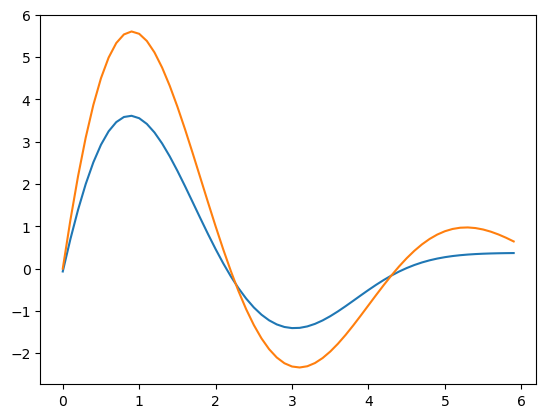

In [6]:
tt = t_coloc.detach().numpy()
yy = y_pred.detach().numpy()
plt.plot(tt, yy)
plt.plot(a_t, asol[:, 0])

In [7]:
new_data_points = y_pred.detach().numpy()
i_response = torch.tensor(new_data_points, requires_grad = True)


In [8]:
class FCNI(nn.Module): # Forward


    def __init__(self, n_input = 1, n_nodes = 5, n_hl = 3, n_output = 1):

        super(FCNI, self).__init__()
        layers = [nn.Linear(n_input, n_nodes), nn.GELU()]
        for _ in range(n_hl - 1):
            layers.append(nn.Linear(n_nodes, n_nodes))
            layers.append(nn.GELU())
        layers.append(nn.Linear(n_nodes, n_output))

        self.layers = nn.Sequential(*layers)
        self.R = nn.Parameter(torch.tensor([0.1], requires_grad = True))
        self.L = nn.Parameter(torch.tensor([0.1], requires_grad = True))
        self.C = nn.Parameter(torch.tensor([0.1], requires_grad = True))

    def forward(self, x):
        return self.layers(x)

model_i = FCNI(n_input = 1, n_nodes = 128, n_hl = 2, n_output = 1)
opt = torch.optim.Adam(model_i.parameters(), lr = 1e-4)


In [9]:
# training loop
epochs = 1000
tr_loss = []

for i in range(epochs):
    for col, resp in zip(t_coloc, i_response):
        l = tr_step_i(model_i, col, resp, t_init, t_init2, i_init, opt)
        tr_loss.append(l)

    if epochs % 10 == 0:
        print(f"Training Loss at epoch {i + 1}: {tr_loss[-1][0]:.6f}")

Training Loss at epoch 1: 145.784348
Training Loss at epoch 2: 144.452850
Training Loss at epoch 3: 139.191345
Training Loss at epoch 4: 116.378792
Training Loss at epoch 5: 44.893848
Training Loss at epoch 6: 6.087223
Training Loss at epoch 7: 4.903105
Training Loss at epoch 8: 3.416248
Training Loss at epoch 9: 2.680203
Training Loss at epoch 10: 2.280404
Training Loss at epoch 11: 2.055806
Training Loss at epoch 12: 1.930971
Training Loss at epoch 13: 1.859264
Training Loss at epoch 14: 1.806143
Training Loss at epoch 15: 1.750821
Training Loss at epoch 16: 1.702157
Training Loss at epoch 17: 1.651004
Training Loss at epoch 18: 1.593737
Training Loss at epoch 19: 1.529938
Training Loss at epoch 20: 1.460585
Training Loss at epoch 21: 1.387048
Training Loss at epoch 22: 1.310664
Training Loss at epoch 23: 1.232639
Training Loss at epoch 24: 1.154062
Training Loss at epoch 25: 1.075954
Training Loss at epoch 26: 0.999305
Training Loss at epoch 27: 0.925036
Training Loss at epoch 28: 0

In [10]:
R, L, C, model_i.R, model_i.L, model_i.C

(tensor([1.2000]),
 tensor([1.5000]),
 tensor([0.3000]),
 Parameter containing:
 tensor([1.4480], requires_grad=True),
 Parameter containing:
 tensor([1.5180], requires_grad=True),
 Parameter containing:
 tensor([0.3254], requires_grad=True))

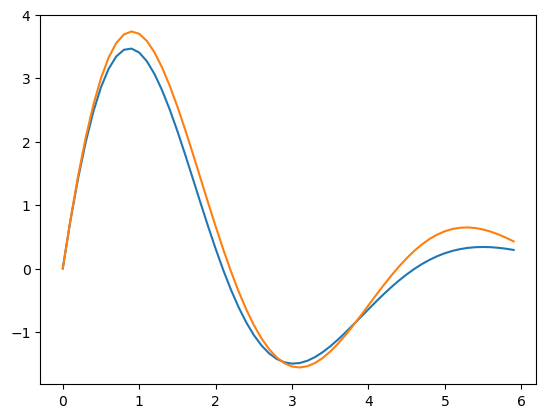

In [12]:
y_pred = model_i(t_coloc)
plt.plot(t_coloc.detach().numpy(), y_pred.detach().numpy())
plt.plot(t_coloc.detach().numpy(), asol[:, 0]/L)
